In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix

from sklearn.feature_selection import SelectFromModel

# Loading the Dataset and Performing Initial Analysis

**Load & Inspect the Data**

In [ ]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Concepts of AI Colab/Assignment 3/Datasets/healthcare-dataset-stroke-data.csv")

# Inspect dataset
df.info()

# Convert categorical features
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0, 'Other': 2})
df['ever_married'] = df['ever_married'].map({'Yes': 1, 'No': 0})
df['work_type'] = df['work_type'].astype('category').cat.codes
df['Residence_type'] = df['Residence_type'].map({'Urban': 1, 'Rural': 0})
df['smoking_status'] = df['smoking_status'].astype('category').cat.codes
df['stroke'] = df['stroke'].astype(int)  # Target variable

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


**Check for Missing Values**

In [ ]:
print("\nMissing Values:\n", df.isnull().sum())

# Fill missing values in BMI column with mean
df['bmi'].fillna(df['bmi'].mean(), inplace=True)

# Ensure all columns are numeric
df = df.astype(float)

# Preview dataset
print("\nPreview of Data:")
print(df.head())


Missing Values:
 id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Preview of Data:
        id  gender   age  hypertension  heart_disease  ever_married  \
0   9046.0     1.0  67.0           0.0            1.0           1.0   
1  51676.0     0.0  61.0           0.0            0.0           1.0   
2  31112.0     1.0  80.0           0.0            1.0           1.0   
3  60182.0     0.0  49.0           0.0            0.0           1.0   
4   1665.0     0.0  79.0           1.0            0.0           1.0   

   work_type  Residence_type  avg_glucose_level        bmi  smoking_status  \
0        2.0             1.0             228.69  36.600000             1.0   
1        3.0             0.0             202.21  28.893237          

<ipython-input-45-361dc7b2549a>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(df['bmi'].mean(), inplace=True)


**Visualizing Data Distribution**

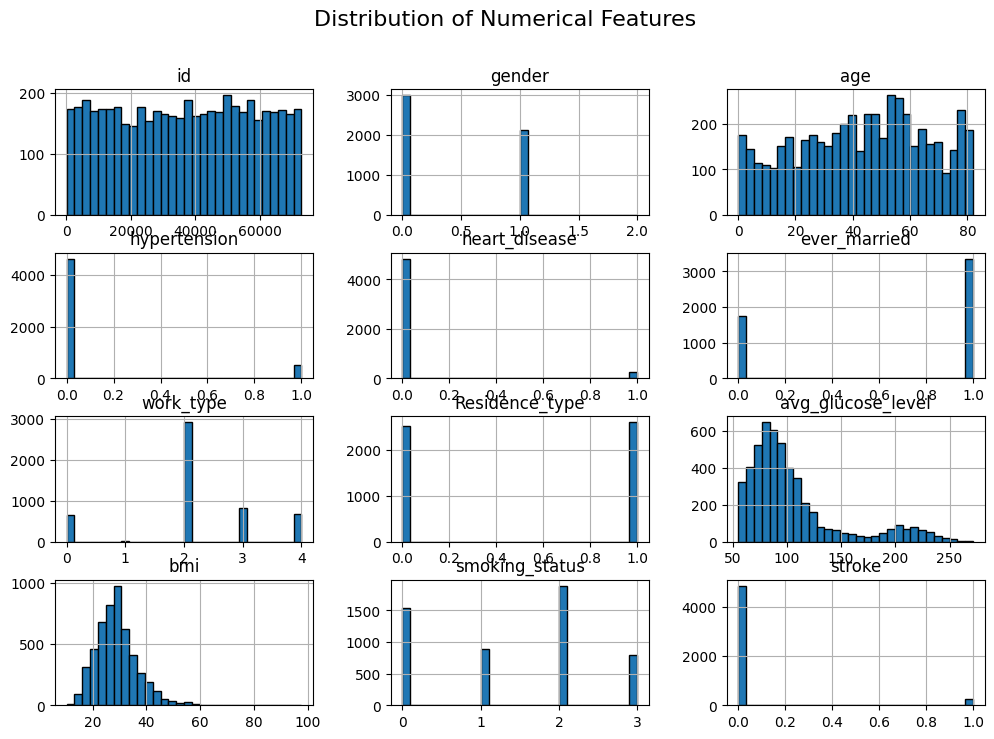

In [ ]:
# Histogram
df.hist(figsize=(12, 8), bins=30, edgecolor='black')
plt.suptitle("Distribution of Numerical Features", fontsize=16)
plt.show()

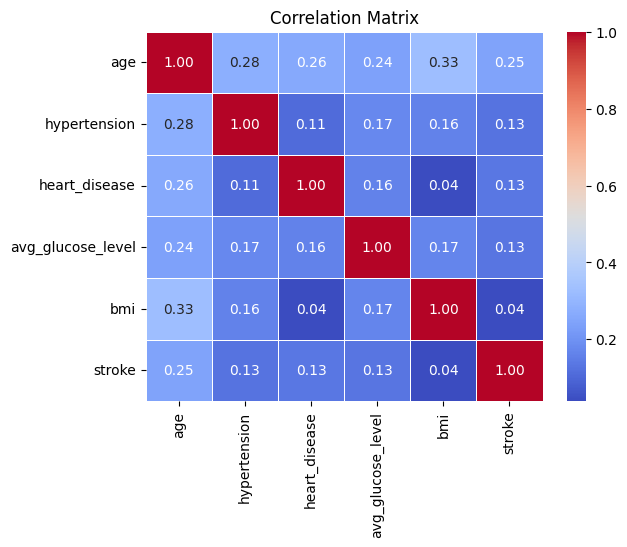

<ipython-input-47-bb7faf5c3e8e>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='stroke', data=df, palette='coolwarm')


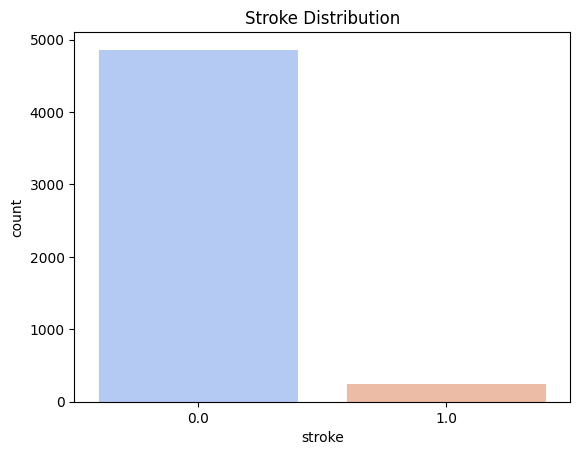

In [ ]:
# Correlation heatmap
selected_cols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']
corr_matrix = df[selected_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

# Visualizing class imbalance
sns.countplot(x='stroke', data=df, palette='coolwarm')
plt.title("Stroke Distribution")
plt.show()

**Split Data into Training & Testing**

In [ ]:
# Features and target
X = df.drop(columns=['id', 'stroke']).values
Y = df['stroke'].values

# Train-test split (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Feature scaling (MinMaxScaler to avoid negative values)
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

print(f"Training Data: {x_train.shape}, Testing Data: {x_test.shape}")

Training Data: (4088, 10), Testing Data: (1022, 10)


In [ ]:
# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# Check new class distribution
print("Class distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

Class distribution after SMOTE:
0.0    3889
1.0    3889
Name: count, dtype: int64


# Build Models

**Implement Logistic Regression from Scratch**

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def gradientDescent(x_train, y_train, epochs, learning_rate):
    n_samples, n_features = x_train.shape
    weights = np.zeros(n_features)
    bias = 0

    for _ in range(epochs):
        linear_model = np.dot(x_train, weights) + bias
        y_predicted = sigmoid(linear_model)

        dw = (1 / n_samples) * np.dot(x_train.T, (y_predicted - y_train))
        db = (1 / n_samples) * np.sum(y_predicted - y_train)

        weights -= learning_rate * dw
        bias -= learning_rate * db

    return weights, bias

def predict(X, weights, bias):
    linear_model = np.dot(X, weights) + bias
    y_predicted = sigmoid(linear_model)
    return [1 if i > 0.5 else 0 for i in y_predicted]

from sklearn.metrics import accuracy_score, classification_report

# Train model
weights, bias = gradientDescent(x_train_resampled, y_train_resampled, 3000, 0.1)

# Make predictions
y_pred_train = predict(x_train, weights, bias)
y_pred_test = predict(x_test, weights, bias)

print(f"Logistic Regression (Scratch) Train Accuracy: {accuracy_score(y_train, y_pred_train)*100:.2f}%")
print(f"Logistic Regression (Scratch) Test Accuracy: {accuracy_score(y_test, y_pred_test)*100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_test, zero_division=1))

Logistic Regression (Scratch) Train Accuracy: 73.41%
Logistic Regression (Scratch) Test Accuracy: 74.66%

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.74      0.85       972
         1.0       0.14      0.80      0.24        50

    accuracy                           0.75      1022
   macro avg       0.56      0.77      0.54      1022
weighted avg       0.94      0.75      0.82      1022



**Train Logistic Regression & Random Forest using Scikit-Learn**

Logistic Regression Test Accuracy: 75.64%
Logistic Regression Train Accuracy: 74.51%

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.75      0.85       972
         1.0       0.14      0.80      0.24        50

    accuracy                           0.76      1022
   macro avg       0.56      0.78      0.55      1022
weighted avg       0.95      0.76      0.82      1022



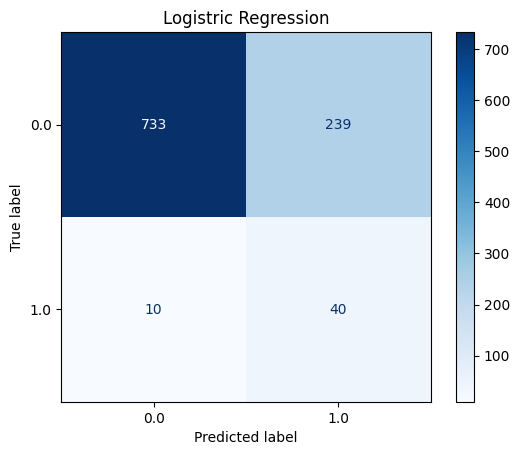

Random Forest Test Accuracy: 91.78%
Random Forest Train Accuracy: 100.00%

Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       972
         1.0       0.17      0.18      0.18        50

    accuracy                           0.92      1022
   macro avg       0.57      0.57      0.57      1022
weighted avg       0.92      0.92      0.92      1022



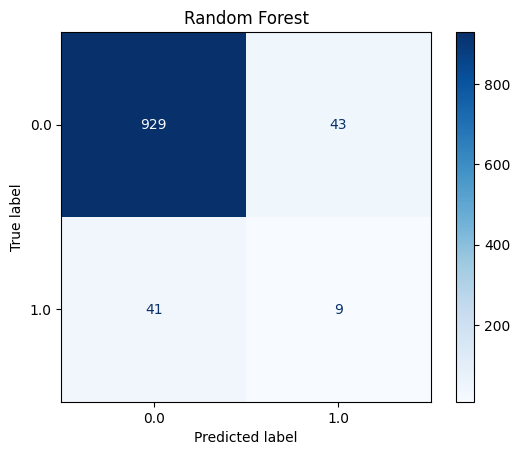

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Train Logistic Regression
log_model = LogisticRegression()
log_model.fit(x_train_resampled, y_train_resampled)

# Make predictions
y_pred = log_model.predict(x_test)
y_pred_train = log_model.predict(x_train)

# Evaluate model
print(f"Logistic Regression Test Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
print(f"Logistic Regression Train Accuracy: {accuracy_score(y_train, y_pred_train)*100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=1))

cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_model.classes_)
cm_display.plot(cmap='Blues', values_format='d')
plt.title("Logistric Regression")
plt.show()

# Train Random Forest with class weighting
rf_model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
rf_model.fit(x_train_resampled, y_train_resampled)

# Predict and evaluate
y_pred_rf = rf_model.predict(x_test)
y_pred__rf_train = rf_model.predict(x_train)
print(f"Random Forest Test Accuracy: {accuracy_score(y_test, y_pred_rf)*100:.2f}%")
print(f"Random Forest Train Accuracy: {accuracy_score(y_train, y_pred__rf_train)*100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf, zero_division=1))

cm_rf = confusion_matrix(y_test, y_pred_rf)

# Display confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=log_model.classes_)
cm_display.plot(cmap='Blues', values_format='d')
plt.title("Random Forest")
plt.show()

# Hyperparameter Tuning

In [ ]:
# Hyperparameter tuning for Logistic Regression
log_reg_params = {"C": [0.01, 0.1, 1, 10], "solver": ["lbfgs", "liblinear"]}
grid_log_reg = GridSearchCV(LogisticRegression(random_state=42), log_reg_params, cv=5, scoring="accuracy")
grid_log_reg.fit(x_train_resampled, y_train_resampled)

print("\nBest Parameters for Logistic Regression:")
print(grid_log_reg.best_params_)

# Hyperparameter tuning for Random Forest
rf_params = {"n_estimators": [50, 100], "max_depth": [None, 10, 20], "min_samples_split": [2, 5]}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring="accuracy")
grid_rf.fit(x_train_resampled, y_train_resampled)

print("\nBest Parameters for Random Forest:")
print(grid_rf.best_params_)



Best Parameters for Logistic Regression:
{'C': 0.1, 'solver': 'liblinear'}

Best Parameters for Random Forest:
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


Logistic Regression Test Accuracy: 74.56%
Logistic Regression Train Accuracy: 73.61%

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.74      0.85       972
         1.0       0.14      0.80      0.24        50

    accuracy                           0.75      1022
   macro avg       0.56      0.77      0.54      1022
weighted avg       0.94      0.75      0.82      1022



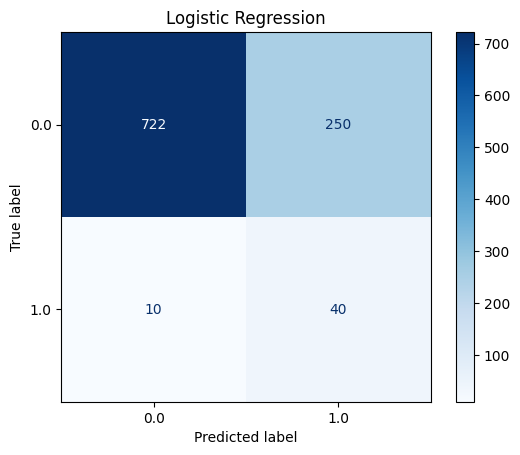

Random Forest Test Accuracy: 91.78%
Random Forest Train Accuracy: 100.00%


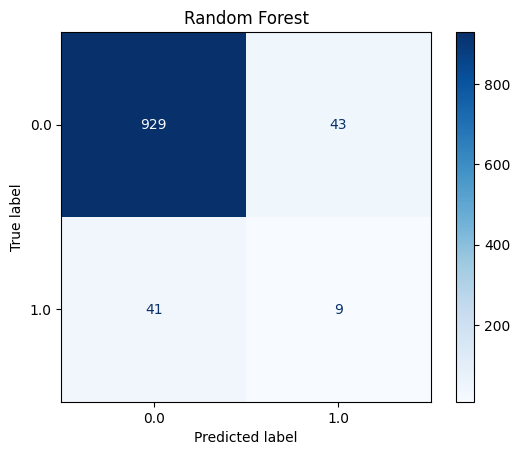

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Train Logistic Regression
log_model = LogisticRegression(C= 0.1, solver= 'liblinear')
log_model.fit(x_train_resampled, y_train_resampled)

# Make predictions
y_pred = log_model.predict(x_test)
y_pred_train = log_model.predict(x_train)

# Evaluate model
print(f"Logistic Regression Test Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
print(f"Logistic Regression Train Accuracy: {accuracy_score(y_train, y_pred_train)*100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=1))

cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_model.classes_)
cm_display.plot(cmap='Blues', values_format='d')
plt.title("Logistic Regression")
plt.show()

# Train Random Forest with class weighting
rf_model = RandomForestClassifier(max_depth= None, min_samples_split= 2, n_estimators= 100, random_state=42)
rf_model.fit(x_train_resampled, y_train_resampled)

# Predict and evaluate
y_pred_rf = rf_model.predict(x_test)
y_pred_rf_train = rf_model.predict(x_train)
print(f"Random Forest Test Accuracy: {accuracy_score(y_test, y_pred_rf)*100:.2f}%")
print(f"Random Forest Train Accuracy: {accuracy_score(y_train, y_pred_rf_train)*100:.2f}%")

cm = confusion_matrix(y_test, y_pred_rf)

# Display confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_model.classes_)
cm_display.plot(cmap='Blues', values_format='d')
plt.title("Random Forest")
plt.show()

# Feature Selection

In [ ]:
log_reg = LogisticRegression()

# Fit the model
log_reg.fit(x_train, y_train)

# Select features based on coefficients
sfm = SelectFromModel(log_reg, threshold="mean", max_features=5)
sfm.fit(x_train, y_train)

# Get the selected features (boolean mask)
selected_features_sfm = sfm.get_support()

X = df.drop(['stroke', 'id'], axis=1) # Drop both 'stroke' and 'id' columns
y = df['stroke']

selected_features_log = X.columns[selected_features_sfm]
print("Selected Features:")
print(selected_features_log)

Selected Features:
Index(['age', 'avg_glucose_level'], dtype='object')


In [ ]:
ran_for = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)

# Fit the model
ran_for.fit(x_train, y_train)

# Select features based on coefficients
sfm = SelectFromModel(ran_for, threshold="mean", max_features=5)
sfm.fit(x_train, y_train)

# Get the selected features (boolean mask)
selected_features_sfm = sfm.get_support()

selected_features_rf = X.columns[selected_features_sfm]
print("Selected Features:")
print(selected_features_rf)

Selected Features:
Index(['age', 'avg_glucose_level', 'bmi'], dtype='object')


# Train Final Model (Random Forest with Selected Features)

Final Random Forest Accuracy (Selected Features): 83.17%

Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.85      0.91       972
         1.0       0.13      0.44      0.20        50

    accuracy                           0.83      1022
   macro avg       0.55      0.65      0.55      1022
weighted avg       0.93      0.83      0.87      1022



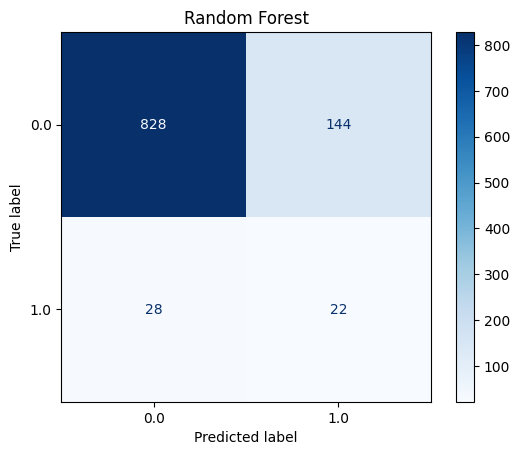

In [ ]:
# Train Random Forest on selected features

X_train_df = pd.DataFrame(x_train_resampled, columns=X.columns) # Use x_train_resampled here
X_test_df = pd.DataFrame(x_test, columns=X.columns)

X_train_top_features = X_train_df[selected_features_rf]
X_test_top_features = X_test_df[selected_features_rf]

final_rf = RandomForestClassifier(max_depth= None, min_samples_split= 2, n_estimators= 100, random_state=42)
final_rf.fit(X_train_top_features, y_train_resampled)

# Make predictions on test set
y_pred_final_rf = final_rf.predict(X_test_top_features)

# Evaluate final model
from sklearn.metrics import accuracy_score, classification_report

print(f"Final Random Forest Accuracy (Selected Features): {accuracy_score(y_test, y_pred_final_rf)*100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_final_rf, zero_division=1))

cm = confusion_matrix(y_test, y_pred_final_rf)

# Display confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_model.classes_)
cm_display.plot(cmap='Blues', values_format='d')
plt.title("Random Forest")
plt.show()